In [1]:
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.datasets as D
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append("../../utils/")
sys.path.append("../")
from torch.utils.data import DataLoader
from utils import MyDataset, Normalize
from tqdm import tqdm
from networks.allaire_net import Allaire_Net
from networks.conv_net import Conv_Net
from networks.conv_net_2 import Conv_Net2
from networks.unet import U_Net
from networks.utils import EarlyStopper
import json
import argparse
import os

In [54]:
transform = Normalize(root="../../data")
dataset = MyDataset(root="../../data", tform=transform)
train_dataset, validation_dataset, test_dataset =torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
train_loader = torch.utils.data.DataLoader(train_dataset)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=16)
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8)

In [55]:
net = U_Net({"cam": True})
net.load_state_dict(torch.load("../networks/weights/U-Net_50.pth"))

Using cache found in /home/lu/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


<All keys matched successfully>

In [56]:
net.eval()

U_Net(
  (base_model): UNet(
    (encoder1): Sequential(
      (enc1conv1): Conv2d(9, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc1relu1): ReLU(inplace=True)
      (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc1relu2): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (encoder2): Sequential(
      (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc2relu1): ReLU(inplace=True)
      (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc2norm2): Batc

In [61]:
n = 0
for x, y in train_loader:
    grad = []
    activation = []
    x_i, x_w = x
    pred = net((x_i, x_w))
    selected_action = pred >= 0.5
    loss = 0
    for i in range(400):
        for j in range(400):
            if selected_action[0, 0, i, j]:
                loss += pred[0,0,i,j]
    if loss:
        net.zero_grad()
        loss.backward()
        gradients = net.get_activations_gradient()
        grads = gradients.data.numpy().squeeze()
        activations = net.get_activations((x_i, x_w))
        fmap = activations.data.numpy().squeeze()
        tmp = grads.reshape(grads.shape[0], -1)
        weights = np.mean(tmp, axis = 1)
        cam = np.zeros(grads.shape[1:])
        for j,w in enumerate(weights):
            cam += w*fmap[j,:]
        cam = cam*(cam>0)
        heatmap = cam/(np.max(cam))
        heatmap = cv2.resize(heatmap, (400, 400))
        heatmap = np.array(heatmap, dtype='f')
        if y.sum() * 0.64 >= 100:
            plt.imsave(f'attention_maps/ewes/{n}.png', heatmap)
        else:
            plt.imsave(f'attention_maps/not_ewes/{n}.png', heatmap)
        n += 1

KeyboardInterrupt: 

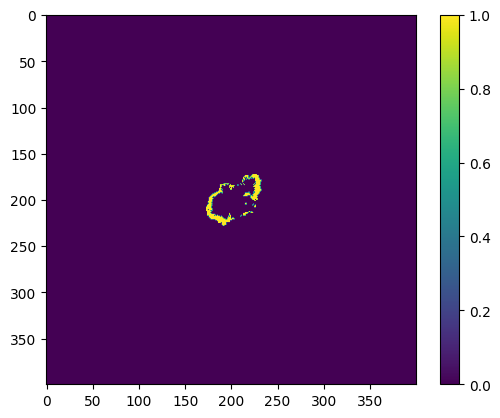

In [ ]:
plt.imshow(y[0])
plt.colorbar()

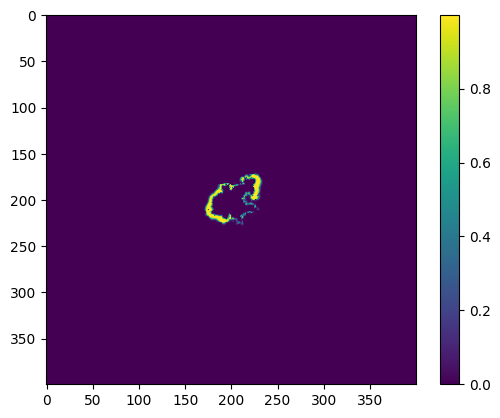

In [ ]:
plt.imshow(pred.data.numpy()[0][0])
plt.colorbar()

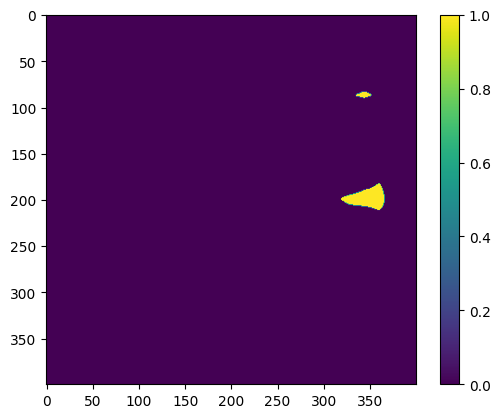

In [48]:
plt.imshow(heatmap > 0.7)
plt.colorbar()